In [2]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
pip install opencv-python ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 779.6/779.6 kB 16.5 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-

In [4]:
!pip install opencv-python-headless

In [5]:
import os
import cv2
import pandas as pd
from ultralytics import YOLO
from tracker import Tracker
import time
import psutil
import matplotlib.pyplot as plt

In [6]:
video_folder = '/content/traffictrim (1).mp4'
result_folder = '/content/drive/MyDrive/TrafficResult1'
os.makedirs(result_folder, exist_ok=True)

100%|██████████| 6.23M/6.23M [00:00<00:00, 210MB/s]


100%|██████████| 49.4M/49.4M [00:00<00:00, 443MB/s]



0: 640x576 3 cars, 1 truck, 109.9ms
Speed: 16.4ms preprocess, 109.9ms inference, 763.5ms postprocess per image at shape (1, 3, 640, 576)

0: 640x576 1 car, 83.9ms
Speed: 2.7ms preprocess, 83.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 576)

0: 640x576 3 cars, 1 truck, 7.7ms
Speed: 3.9ms preprocess, 7.7ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 576)

0: 640x576 (no detections), 47.3ms
Speed: 3.6ms preprocess, 47.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 576)

0: 640x576 4 cars, 1 truck, 7.7ms
Speed: 3.8ms preprocess, 7.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 576)



/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


Streaming output truncated to the last 5000 lines.
0: 640x576 2 persons, 1 car, 24.2ms
Speed: 3.3ms preprocess, 24.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 576)

0: 640x576 5 cars, 1 truck, 11.5ms
Speed: 6.4ms preprocess, 11.5ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 576)

0: 640x576 1 person, 1 car, 24.7ms
Speed: 3.3ms preprocess, 24.7ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 576)

0: 640x576 5 cars, 1 truck, 8.6ms
Speed: 4.0ms preprocess, 8.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 576)

0: 640x576 1 person, 1 car, 23.9ms
Speed: 3.3ms preprocess, 23.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 576)

0: 640x576 5 cars, 1 truck, 6.8ms
Speed: 3.8ms preprocess, 6.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 576)

0: 640x576 1 car, 24.3ms
Speed: 3.1ms preprocess, 24.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 576)

0: 640x576 5 cars, 1 truck, 7.6

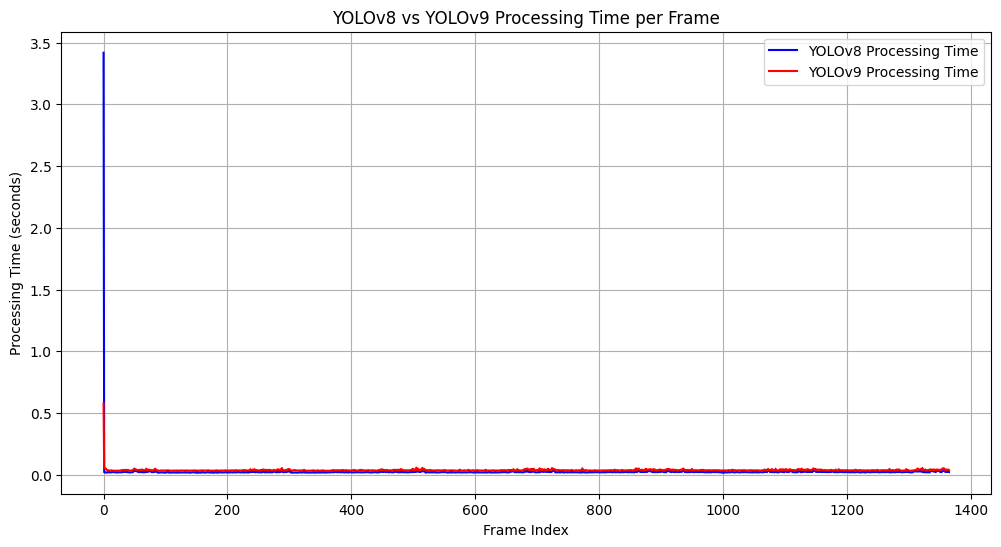

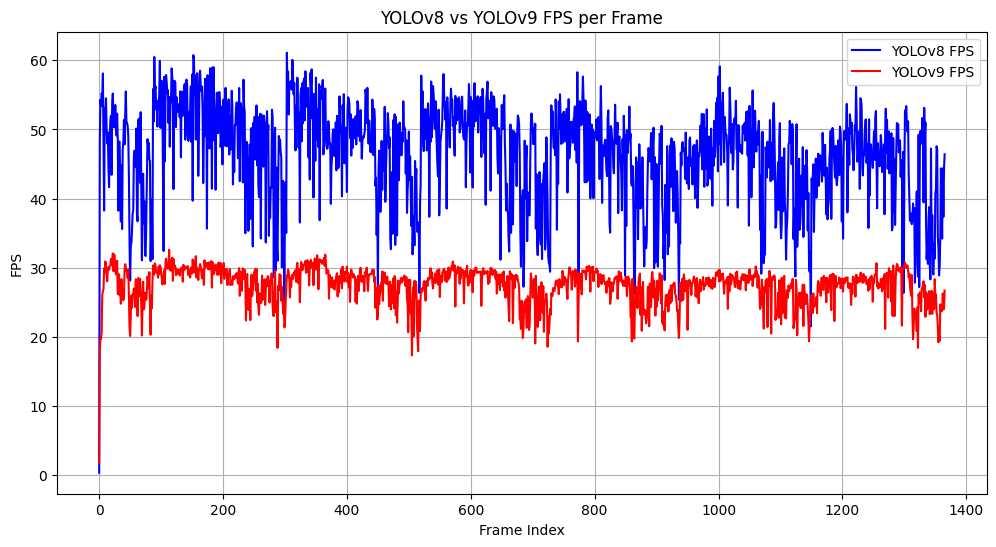

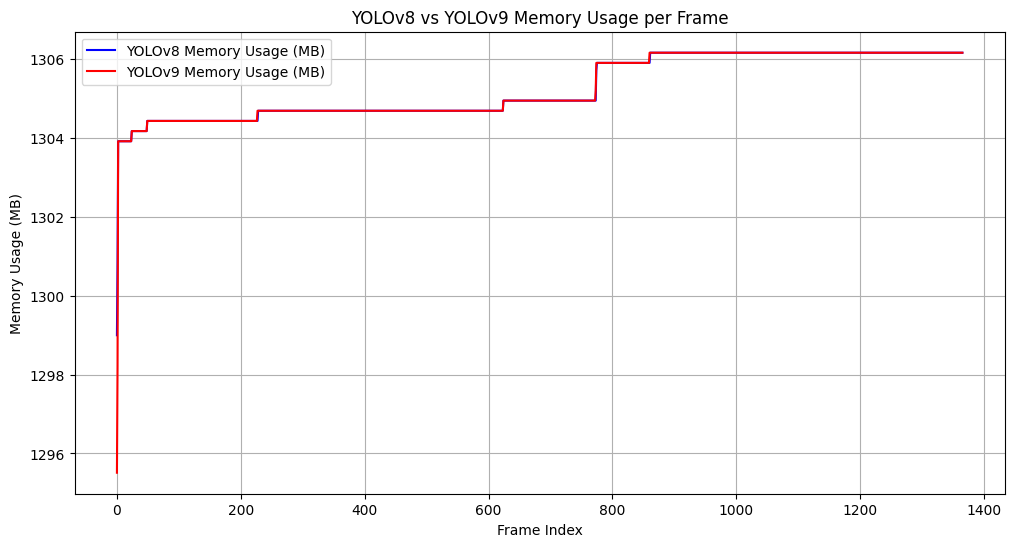

    Model  Accurate Detections  False Positives  False Negatives
0  YOLOv8                 5541             1142                0
1  YOLOv9                 2369             1018              124
Frames processed with YOLOv8: 1366
Frames processed with YOLOv9: 1366


In [7]:
def process_video(video_path, yolov8_model, yolov9_model):
    """Processes a video with both YOLOv8 and YOLOv9, collecting processing times and other metrics."""
    cap = cv2.VideoCapture(video_path)
    video_name = os.path.splitext(os.path.basename(video_path))[0]
    output_video_path = os.path.join(result_folder, f'{video_name}_comparison_result.mp4')
    fourcc = cv2.VideoWriter_fourcc(*'MP4V')
    out = cv2.VideoWriter(output_video_path, fourcc, 30.0, (int(cap.get(3)), int(cap.get(4))))
    down = {}
    counter_down = set()
    yolov8_processing_times = []
    yolov9_processing_times = []
    yolov8_accurate_detections = 0
    yolov9_accurate_detections = 0
    yolov8_false_positives = 0
    yolov9_false_positives = 0
    yolov8_false_negatives = 0
    yolov9_false_negatives = 0
    yolov8_fps = []
    yolov9_fps = []
    yolov8_memory_usage = []
    yolov9_memory_usage = []

    try:
        tracker = Tracker()
        class_list = ['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']

        while True:
            ret, frame = cap.read()
            if not ret:
                break

            combined_frame = frame.copy()

            # Process with YOLOv8 (left side)
            start_time_yolov8 = time.time()
            results_yolov8 = yolov8_model(frame[:, :frame.shape[1] // 2])
            boxes_yolov8 = results_yolov8[0].boxes.data.cpu().numpy()
            stop_time_yolov8 = time.time() - start_time_yolov8
            yolov8_processing_times.append(stop_time_yolov8)
            yolov8_fps.append(1 / stop_time_yolov8)
            yolov8_memory_usage.append(psutil.Process().memory_info().rss / 1024 ** 2)

            bbox_list_yolov8 = []
            for box in boxes_yolov8:
                x1, y1, x2, y2, _, class_id = box
                if int(class_id) < len(class_list) and class_list[int(class_id)] == 'car':
                    bbox_list_yolov8.append([int(x1), int(y1), int(x2), int(y2)])
                    yolov8_accurate_detections += 1
                else:
                    yolov8_false_positives += 1

            if len(bbox_list_yolov8) == 0:
                yolov8_false_negatives += 1

            bbox_id_yolov8 = tracker.update(bbox_list_yolov8)
            for bbox in bbox_id_yolov8:
                x3, y3, x4, y4, id = bbox
                cx = (x3 + x4) // 2
                cy = (y3 + y4) // 2

                cv2.circle(combined_frame[:, :frame.shape[1] // 2], (cx, cy), 4, (0, 255, 0), -1)
                cv2.putText(combined_frame[:, :frame.shape[1] // 2], str(id), (cx, cy), cv2.FONT_HERSHEY_COMPLEX, 0.8, (0, 255, 0), 2, cv2.LINE_AA)
                cv2.putText(combined_frame[:, :frame.shape[1] // 2], f'YOLOv8', (20, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2, cv2.LINE_AA)
                cv2.putText(combined_frame[:, :frame.shape[1] // 2], f'Time: {stop_time_yolov8:.2f}s', (20, 50), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2, cv2.LINE_AA)

            # Process with YOLOv9 (right side)
            start_time_yolov9 = time.time()
            results_yolov9 = yolov9_model(frame[:, frame.shape[1] // 2:])
            boxes_yolov9 = results_yolov9[0].boxes.data.cpu().numpy()
            stop_time_yolov9 = time.time() - start_time_yolov9
            yolov9_processing_times.append(stop_time_yolov9)
            yolov9_fps.append(1 / stop_time_yolov9)
            yolov9_memory_usage.append(psutil.Process().memory_info().rss / 1024 ** 2)

            bbox_list_yolov9 = []
            for box in boxes_yolov9:
                x1, y1, x2, y2, _, class_id = box
                if int(class_id) < len(class_list) and class_list[int(class_id)] == 'car':
                    bbox_list_yolov9.append([int(x1) + frame.shape[1] // 2, int(y1), int(x2) + frame.shape[1] // 2, int(y2)])
                    yolov9_accurate_detections += 1
                else:
                    yolov9_false_positives += 1

            if len(bbox_list_yolov9) == 0:
                yolov9_false_negatives += 1

            bbox_id_yolov9 = tracker.update(bbox_list_yolov9)
            for bbox in bbox_id_yolov9:
                x3, y3, x4, y4, id = bbox
                cx = (x3 + x4) // 2
                cy = (y3 + y4) // 2

                cv2.circle(combined_frame[:, frame.shape[1] // 2:], (cx, cy), 4, (0, 0, 255), -1)
                cv2.putText(combined_frame[:, frame.shape[1] // 2:], str(id), (cx, cy), cv2.FONT_HERSHEY_COMPLEX, 0.8, (0, 0, 255), 2, cv2.LINE_AA)
                cv2.putText(combined_frame[:, frame.shape[1] // 2:], f'YOLOv9', (20, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2, cv2.LINE_AA)
                cv2.putText(combined_frame[:, frame.shape[1] // 2:], f'Time: {stop_time_yolov9:.2f}s', (20, 50), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2, cv2.LINE_AA)

            # Draw red line and car count (combined)
            red_color = (0, 0, 255)
            cv2.line(combined_frame, (282, 308), (1004, 308), red_color, 3)
            cv2.putText(combined_frame, 'red line', (280, 308), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1, cv2.LINE_AA)
            downwards = len(counter_down)
            cv2.putText(combined_frame, f'going down - {downwards}', (60, 40), cv2.FONT_HERSHEY_SIMPLEX, 0.5, red_color, 1, cv2.LINE_AA)

            for bbox_id in bbox_id_yolov8:
                x3, y3, x4, y4, id = bbox_id
                if y3 > 308 and id not in counter_down:
                    down[id] = y3
                    counter_down.add(id)
            for bbox_id in bbox_id_yolov9:
                x3, y3, x4, y4, id = bbox_id
                if y3 > 308 + frame.shape[1] // 2 and id not in counter_down:
                    down[id] = y3
                    counter_down.add(id)

            out.write(combined_frame)

    except Exception as e:
        print(f"Error processing video '{video_path}': {e}")
        raise

    cap.release()
    out.release()

    return {
        'yolov8_processing_times': yolov8_processing_times,
        'yolov9_processing_times': yolov9_processing_times,
        'yolov8_accurate_detections': yolov8_accurate_detections,
        'yolov9_accurate_detections': yolov9_accurate_detections,
        'yolov8_false_positives': yolov8_false_positives,
        'yolov9_false_positives': yolov9_false_positives,
        'yolov8_false_negatives': yolov8_false_negatives,
        'yolov9_false_negatives': yolov9_false_negatives,
        'yolov8_fps': yolov8_fps,
        'yolov9_fps': yolov9_fps,
        'yolov8_memory_usage': yolov8_memory_usage,
        'yolov9_memory_usage': yolov9_memory_usage
    }

if __name__ == '__main__':
    video_folder = '/content/traffictrim (1).mp4'
    result_folder = '/content/drive/MyDrive/TrafficResult1'

    if not os.path.exists(result_folder):
        os.makedirs(result_folder)

    yolov8_model = YOLO('yolov8n.pt')
    yolov9_model = YOLO('yolov9c.pt')

    comparison_metrics = process_video(video_folder, yolov8_model, yolov9_model)

    # Collect processing times
    all_yolov8_times = comparison_metrics['yolov8_processing_times']
    all_yolov9_times = comparison_metrics['yolov9_processing_times']

    # Optional: Generate performance graphs
    try:
        plt.figure(figsize=(12, 6))
        plt.plot(all_yolov8_times, label='YOLOv8 Processing Time', color='blue')
        plt.plot(all_yolov9_times, label='YOLOv9 Processing Time', color='red')
        plt.xlabel('Frame Index')
        plt.ylabel('Processing Time (seconds)')
        plt.title('YOLOv8 vs YOLOv9 Processing Time per Frame')
        plt.legend()
        plt.grid(True)
        plt.savefig(os.path.join(result_folder, 'performance_comparison_processing_time.png'))
        plt.show()

        plt.figure(figsize=(12, 6))
        plt.plot(comparison_metrics['yolov8_fps'], label='YOLOv8 FPS', color='blue')
        plt.plot(comparison_metrics['yolov9_fps'], label='YOLOv9 FPS', color='red')
        plt.xlabel('Frame Index')
        plt.ylabel('FPS')
        plt.title('YOLOv8 vs YOLOv9 FPS per Frame')
        plt.legend()
        plt.grid(True)
        plt.savefig(os.path.join(result_folder, 'performance_comparison_fps.png'))
        plt.show()

        plt.figure(figsize=(12, 6))
        plt.plot(comparison_metrics['yolov8_memory_usage'], label='YOLOv8 Memory Usage (MB)', color='blue')
        plt.plot(comparison_metrics['yolov9_memory_usage'], label='YOLOv9 Memory Usage (MB)', color='red')
        plt.xlabel('Frame Index')
        plt.ylabel('Memory Usage (MB)')
        plt.title('YOLOv8 vs YOLOv9 Memory Usage per Frame')
        plt.legend()
        plt.grid(True)
        plt.savefig(os.path.join(result_folder, 'performance_comparison_memory_usage.png'))
        plt.show()

        # Detection accuracy, false positives, and false negatives
        metrics_data = {
            'Model': ['YOLOv8', 'YOLOv9'],
            'Accurate Detections': [comparison_metrics['yolov8_accurate_detections'], comparison_metrics['yolov9_accurate_detections']],
            'False Positives': [comparison_metrics['yolov8_false_positives'], comparison_metrics['yolov9_false_positives']],
            'False Negatives': [comparison_metrics['yolov8_false_negatives'], comparison_metrics['yolov9_false_negatives']]
        }
        df = pd.DataFrame(metrics_data)
        print(df)

    except ImportError as e:
        print("matplotlib or pandas is not installed, skipping the performance graph generation.")
    except Exception as e:
        print(f"Error generating performance graph: {e}")

    print(f"Frames processed with YOLOv8: {len(all_yolov8_times)}")
    print(f"Frames processed with YOLOv9: {len(all_yolov9_times)}")

# Destroy all windows
cv2.destroyAllWindows()
